In [ ]:
%matplotlib inline
import os
import numpy as np
import json
from tqdm import tqdm
from ultralytics.utils import ops

from inference import Detector, Classificator, Inference
from inference.Inference import quantify 

# Object detection
from data.load import load_yolo, loader, load_as_coco
from metrics.coco import CocoEvaluator
from metrics.utils import get_classify_ground_truth

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    explained_variance_score,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
config = {
    "val_source": "../datasets/orobanche_cummana/autosplit_val.txt",
    "detect_model_path": os.path.normpath("./runs/detect/train2/weights/best.pt"),
    "classify_model_path": os.path.normpath("./runs/classify/train/weights/best.pt"),
    'results': 'results',
    
    "to_classes": {
      0: "background",
      1: "healthy",
      2: "necrotic", 
    },
    
    #DETECTION
    "device": 0,
    "overlap": 0.2,
    "patch_size": 1024,
    "size_factor": 1.0,
    "conf_thresh": 0.25,
    "nms_iou_thresh":  0.7,
    "max_patch_detections": 300,
    "patch_per_batch": 4,
    "pre_wbf_detections":  3000,
    "wbf_ios_thresh": 0.5,
    "max_detections": 1000,
    
    #CLASSIFICATION (INFERENCE)
    "offset": 0.1,
    "classify_img_size": 224,
    
    #CLASSIFICATION (EVALUATION)
    "bg_iou_thresh": 0.7,
}

In [16]:
detect = Detector(
    model_path=config["detect_model_path"],
    device=config["device"],
    overlap=config["overlap"],
    patch_size=config["patch_size"],
    size_factor=config["size_factor"],
    conf_thresh=config["conf_thresh"],
    nms_iou_thresh=config["nms_iou_thresh"],
    max_patch_detections=config["max_patch_detections"],
    patch_per_batch=config["patch_per_batch"],
    pre_wbf_detections=config["pre_wbf_detections"],
    wbf_ios_thresh=config["wbf_ios_thresh"],
    max_detections=config["max_detections"],
    single_cls=True,
)

classify = Classificator(
    model_path=config["classify_model_path"], 
    device=config["device"], 
    img_size=config["classify_img_size"],
)

inference = Inference(detect, classify, offset=config['offset'])
os.makedirs(config['results'], exist_ok=True)

In [5]:
detection_gt = {k: np.asarray(v) for k, v in load_yolo(config["val_source"]).items()}
coco_gt_detection, names_to_ids = load_as_coco(config["val_source"], config["to_classes"])
coco_detection_evaluator = CocoEvaluator(coco_gt_detection)

In [ ]:
process_image_profiler = ops.Profile(device=0)

def process_image(image_name, image, inference: Inference, detection_gt, config):
    """Process a single image through the detection and classification pipeline."""
    class_num = len(config["to_classes"])
    results = {
        "image_name": image_name,
        "detect_prediction": None,
        "classify_prediction": [],
        "classify_gt": [],
        "inference_prediction": {},
        "quantification_gt": {
            "areas": np.zeros(class_num, dtype=np.float64),
            "counts": np.zeros(class_num, dtype=np.uint64)
        },
        "quantification_prediction": {
            "areas": np.zeros(class_num, dtype=np.float64),
            "counts": np.zeros(class_num, dtype=np.uint64)
        }
    }
    
    # Detection step
    results["detect_prediction"] = inference.detect(image)
    
    # Get patches
    patched_images, patches = inference.patch(image, results["detect_prediction"].boxes)
    
    if patches:
    
        
        # Classification step
        results["classify_prediction"], confidences = inference.classify(patched_images)
        
        # Get ground truth for classification
        results["classify_gt"] = get_classify_ground_truth(
            results["detect_prediction"].boxes.xyxy,
            detection_gt[image_name][:, :4],
            detection_gt[image_name][:, 4],
            config["bg_iou_thresh"],
        )
        
        # Merge detection and classification
        results["inference_prediction"] = inference.merge_detect_and_classification(
            image,
            results["detect_prediction"].boxes.data,
            results["classify_prediction"],
            confidences,
        )
        
        # Save detection visualization
        # results["inference_prediction"].plot(
        #     img=np.asarray(image)[..., ::-1],
        #     filename=f"{config['results']}/{image_name}.jpg",
        #     save=True,
        #     line_width=5,
        #     font_size=16,
        # )
        
        # Quantify ground truth and predictions
        results["quantification_gt"] = quantify(
            detection_gt[image_name][:, :4],
            detection_gt[image_name][:, 4],
            class_num,
        )
        
        results["quantification_prediction"] = quantify(
            results["inference_prediction"].boxes.xyxy,
            results["inference_prediction"].boxes.cls,
            class_num,
        )
    
    return results

# Process all images
class_num = len(config["to_classes"])
image_results = []
image_loader = loader(config["val_source"])

for image_name, image in tqdm(image_loader):
    image_results.append(process_image(image_name, image, inference, detection_gt, config))

88it [31:31, 21.50s/it]


In [17]:
def structure_results(image_results, class_num):
    """Organize image-level results into structured collections for evaluation."""
    detect_predictions = {}
    classify_predictions = {}
    classify_gt = {}
    inference_predictions = {}
    quantification_gt = {}
    quantification_predictions = {}
    
    classify_predictions_flat = []
    classify_gt_flat = []
    
    # Process each image result
    for result in image_results:
        image_name = result["image_name"]
        
        # Store detection and inference predictions
        detect_predictions[image_name] = result["detect_prediction"]
        
        # Store classification data
        classify_predictions[image_name] = result["classify_prediction"]
        classify_gt[image_name] = result["classify_gt"]
        
        # Extend flat lists for classification
        classify_predictions_flat.extend(result["classify_prediction"])
        classify_gt_flat.extend(result["classify_gt"])
        
        # Store inference predictions
        inference_predictions[image_name] = result["inference_prediction"]
        
        # Store quantification data
        quantification_gt[image_name] = result["quantification_gt"]
        quantification_predictions[image_name] = result["quantification_prediction"]
    
    # Create flattened quantification arrays
    num_images = len(quantification_gt)
    
    quantification_gt_flat = {
        "areas": np.zeros((num_images, class_num), dtype=np.float64),
        "counts": np.zeros((num_images, class_num), dtype=np.uint64),
    }
    
    quantification_predictions_flat = {
        "areas": np.zeros((num_images, class_num), dtype=np.float64),
        "counts": np.zeros((num_images, class_num), dtype=np.uint64),
    }
    
    # Fill quantification arrays
    for idx, image_name in enumerate(quantification_gt.keys()):
        gt = quantification_gt[image_name]
        pred = quantification_predictions[image_name]
        
        quantification_gt_flat["areas"][idx] = gt["areas"]
        quantification_gt_flat["counts"][idx] = gt["counts"]
        quantification_predictions_flat["areas"][idx] = pred["areas"]
        quantification_predictions_flat["counts"][idx] = pred["counts"]
    
    return {
        "detect_predictions": detect_predictions,
        "classify_predictions": classify_predictions,
        "classify_gt": classify_gt,
        "inference_predictions": inference_predictions,
        "quantification_gt": quantification_gt,
        "quantification_predictions": quantification_predictions,
        "classify_predictions_flat": classify_predictions_flat,
        "classify_gt_flat": classify_gt_flat,
        "quantification_gt_flat": quantification_gt_flat,
        "quantification_predictions_flat": quantification_predictions_flat
    }

# Structure all results
all_results = structure_results(image_results, class_num)

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.19s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.106
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.046
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.186
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

C:\Users\maksi\AppData\Local\Temp\ipykernel_16040\1151921438.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(ap_metrics.keys()), y=list(ap_metrics.values()), palette="coolwarm")


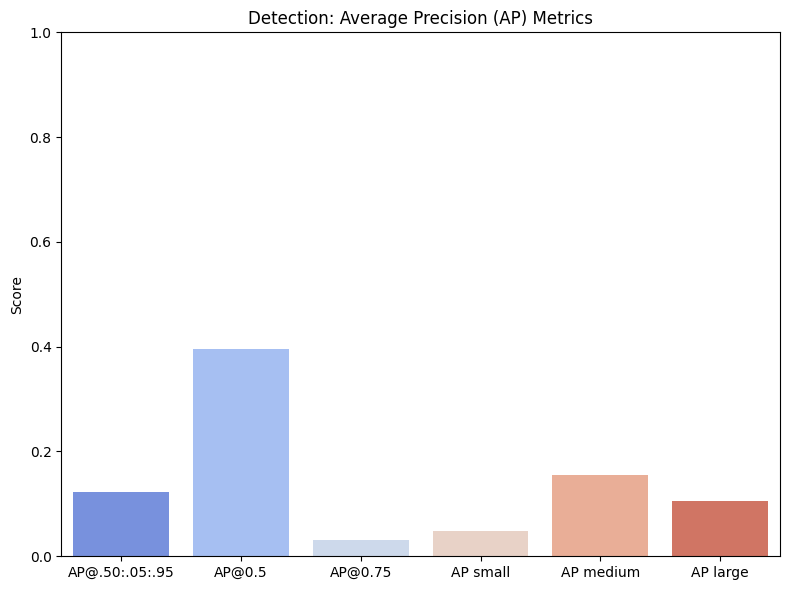

C:\Users\maksi\AppData\Local\Temp\ipykernel_16040\1151921438.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(ar_metrics.keys()), y=list(ar_metrics.values()), palette="viridis")


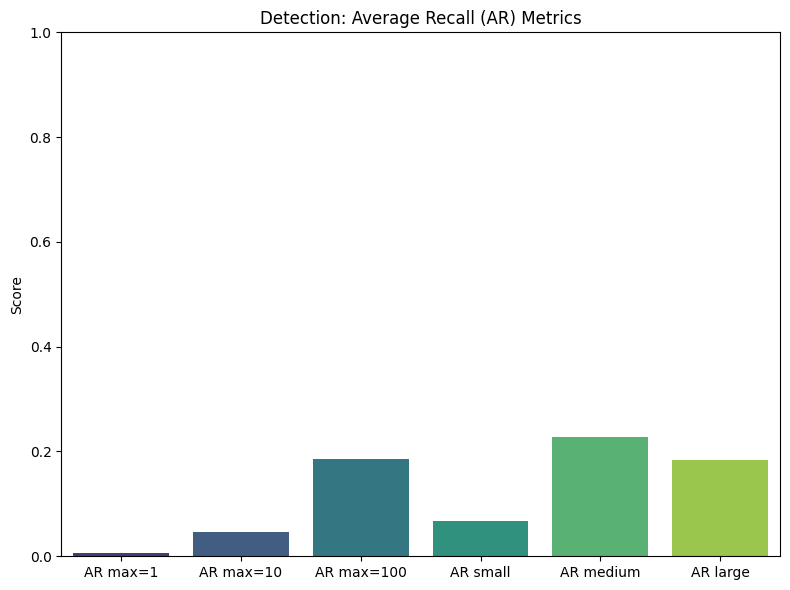

In [18]:
def plot_detection_metrics(results, title_prefix=""):
    """Plot detection metrics in an organized way."""
    # Separate AP and AR metrics for better visualization
    ap_metrics = {k: v for k, v in results.items() if k.startswith("AP")}
    ar_metrics = {k: v for k, v in results.items() if k.startswith("AR")}
    
    # Plot AP metrics
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(ap_metrics.keys()), y=list(ap_metrics.values()), palette="coolwarm")
    plt.title(f"{title_prefix}Average Precision (AP) Metrics")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    # Plot AR metrics
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(ar_metrics.keys()), y=list(ar_metrics.values()), palette="viridis")
    plt.title(f"{title_prefix}Average Recall (AR) Metrics")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

# Evaluate detection results
detect_results = coco_detection_evaluator.eval(
    all_results["detect_predictions"], names_to_ids, useCats=False
)

with open(os.path.join(config['results'], 'detect_coco.json'), "w") as f:
    json.dump(detect_results, f, indent=4)

# Plot detection metrics
plot_detection_metrics(detect_results, "Detection: ")

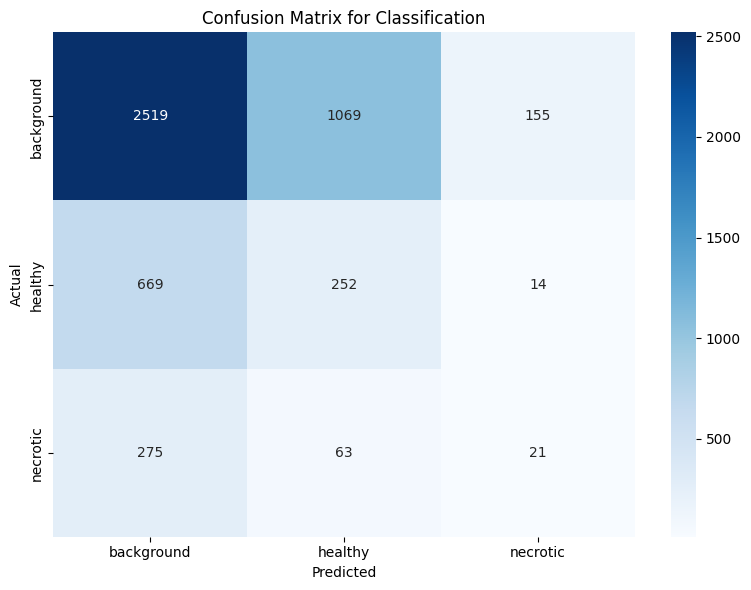

C:\Users\maksi\AppData\Local\Temp\ipykernel_16040\1754324476.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="viridis")


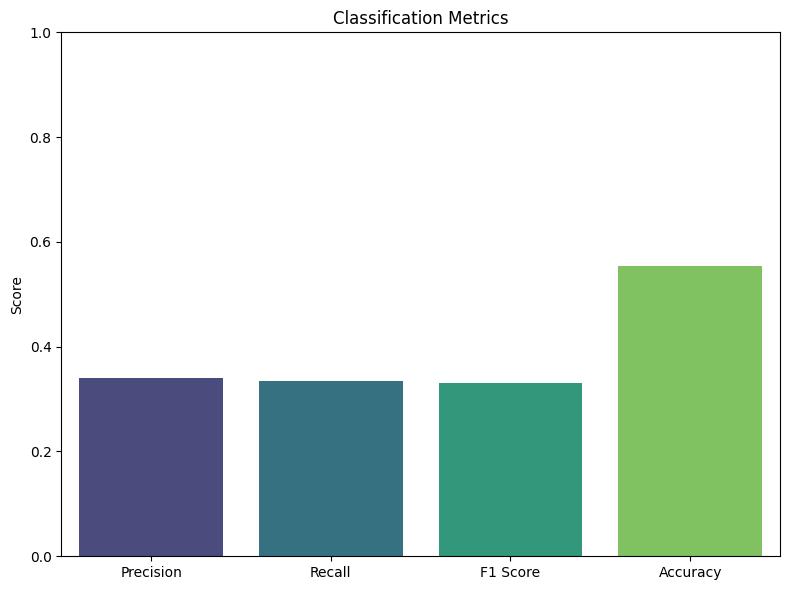

In [19]:
def evaluate_classification(predictions, ground_truth, class_names):
    """Evaluate classification metrics and plot results."""
    precision = precision_score(ground_truth, predictions, average='macro')
    recall = recall_score(ground_truth, predictions, average='macro')
    f1 = f1_score(ground_truth, predictions, average='macro')
    accuracy = accuracy_score(ground_truth, predictions)
    
    # Plot confusion matrix
    cm = confusion_matrix(ground_truth, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(class_names.values()),
                yticklabels=list(class_names.values()))
    plt.title(f'Confusion Matrix for Classification')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    # Plot metrics
    metrics = {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Accuracy": accuracy,
    }
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="viridis")
    plt.title("Classification Metrics")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    return metrics

# Evaluate classification results
classification_metrics = evaluate_classification(
    all_results["classify_predictions_flat"], 
    all_results["classify_gt_flat"],
    config["to_classes"]
)

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=227.72s).
Accumulating evaluation results...
DONE (t=35.74s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets

C:\Users\maksi\AppData\Local\Temp\ipykernel_16040\1151921438.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(ap_metrics.keys()), y=list(ap_metrics.values()), palette="coolwarm")


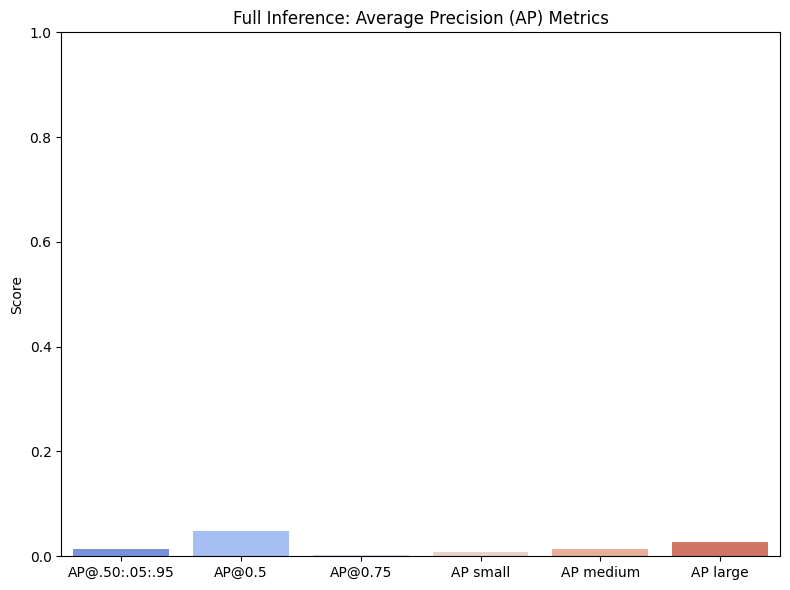

C:\Users\maksi\AppData\Local\Temp\ipykernel_16040\1151921438.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(ar_metrics.keys()), y=list(ar_metrics.values()), palette="viridis")


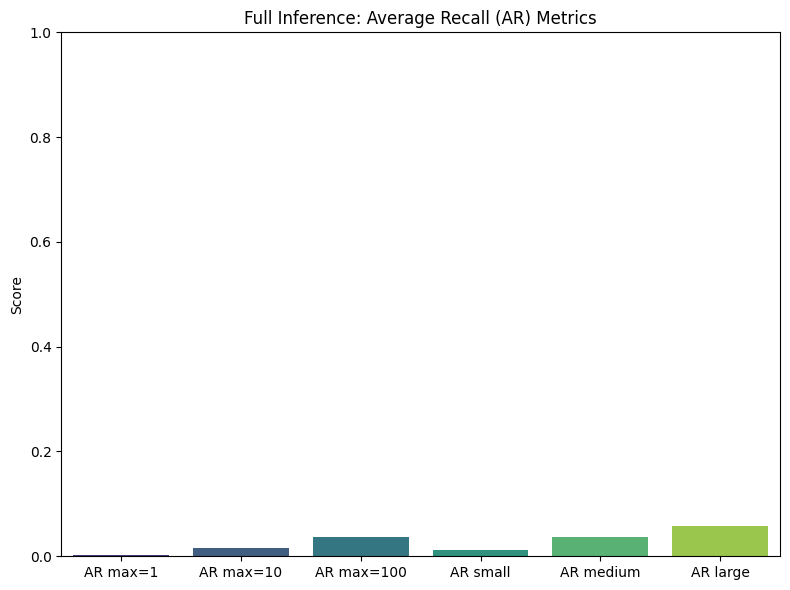

In [22]:
infere_results = coco_detection_evaluator.eval(
    all_results["inference_predictions"], names_to_ids, useCats=True
)

with open(os.path.join(config['results'], 'inference_coco.json'), "w") as f:
    json.dump(infere_results, f, indent=4)

# Plot inference metrics
plot_detection_metrics(infere_results, "Full Inference: ")

In [32]:
def evaluate_quantification_metrics(gt_values, pred_values, class_names, metric_type="Area"):
    """Calculate and return quantification metrics."""
    metrics = {}
    
    # Per-class metrics
    for class_id, class_name in class_names.items():
        if class_id != 0:  # Skip background
            gt = gt_values[:, class_id]
            pred = pred_values[:, class_id]
            
            # Skip if no ground truth
            if np.sum(gt) == 0:
                continue
                
            metrics[class_name] = {
                "Explained Variance": explained_variance_score(gt, pred),
                #"MAE": mean_absolute_error(gt, pred),
                "R2": r2_score(gt, pred),
              #  "MAPE": mean_absolute_percentage_error(gt, pred) if np.any(gt != 0) else float('nan'),
            }
    
    # Overall metrics (excluding background)
    all_gt = gt_values[:, 1:].sum(axis=1)
    all_pred = pred_values[:, 1:].sum(axis=1)
    
    if np.sum(all_gt) > 0:
        metrics["All Classes"] = {
            "Explained Variance": explained_variance_score(all_gt, all_pred),
            #"MAE": mean_absolute_error(all_gt, all_pred),
            "R2": r2_score(all_gt, all_pred),
           # "MAPE": mean_absolute_percentage_error(all_gt, all_pred) if np.any(all_gt != 0) else float('nan'),
        }
    
    return metrics

def plot_quantification_metrics(metrics, title_prefix=""):
    """Plot quantification metrics for each class."""
    for name, class_metrics in metrics.items():
        valid_metrics = {k: v for k, v in class_metrics.items() if not np.isnan(v)}
        
        if not valid_metrics:
            continue
            
        plt.figure(figsize=(8, 6))
        sns.barplot(x=list(valid_metrics.keys()), y=list(valid_metrics.values()))
        plt.title(f"{title_prefix} Metrics for {name}")
        plt.ylabel("Score")
        plt.tight_layout()
        plt.show()

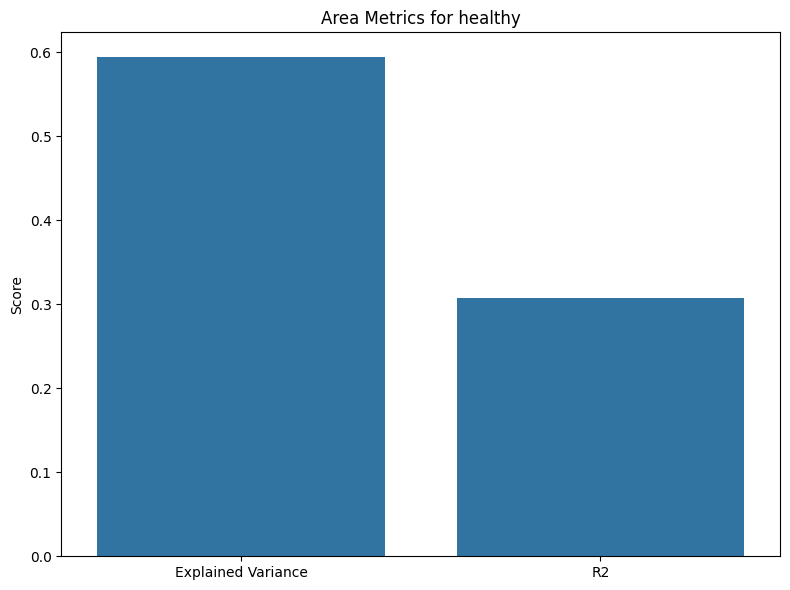

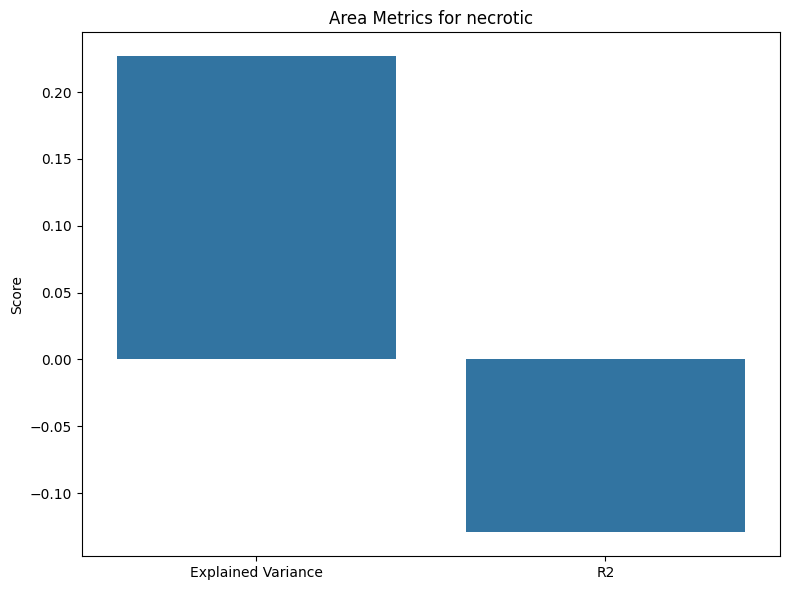

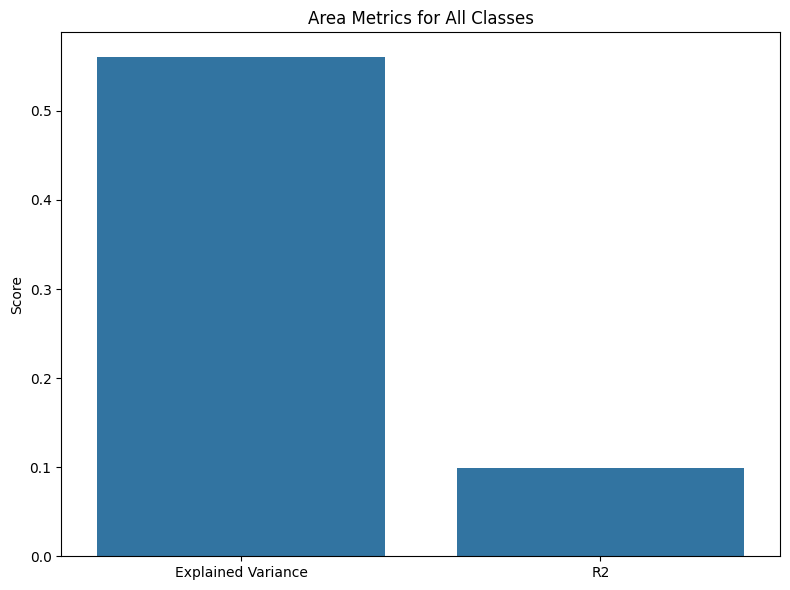

In [33]:
area_metrics = evaluate_quantification_metrics(
    all_results["quantification_gt_flat"]["areas"],
    all_results["quantification_predictions_flat"]["areas"],
    config["to_classes"],
    "Area"
)



plot_quantification_metrics(area_metrics, "Area")

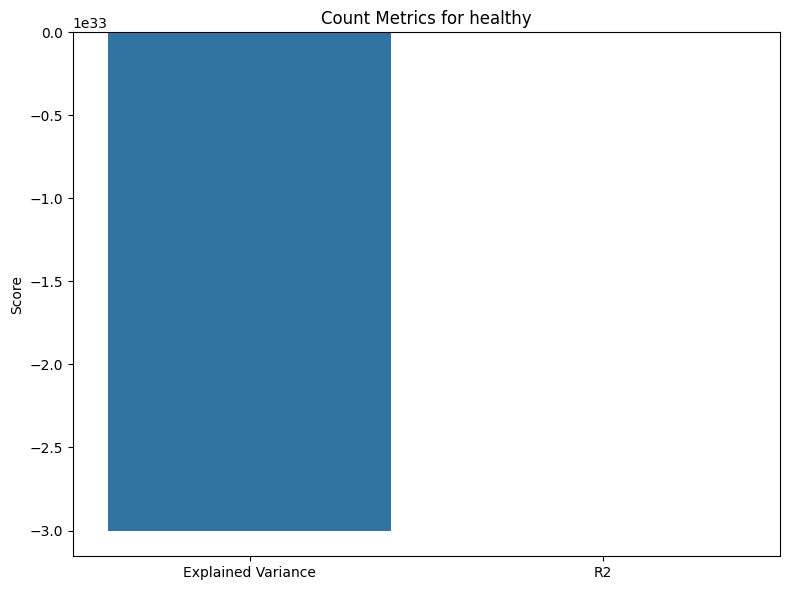

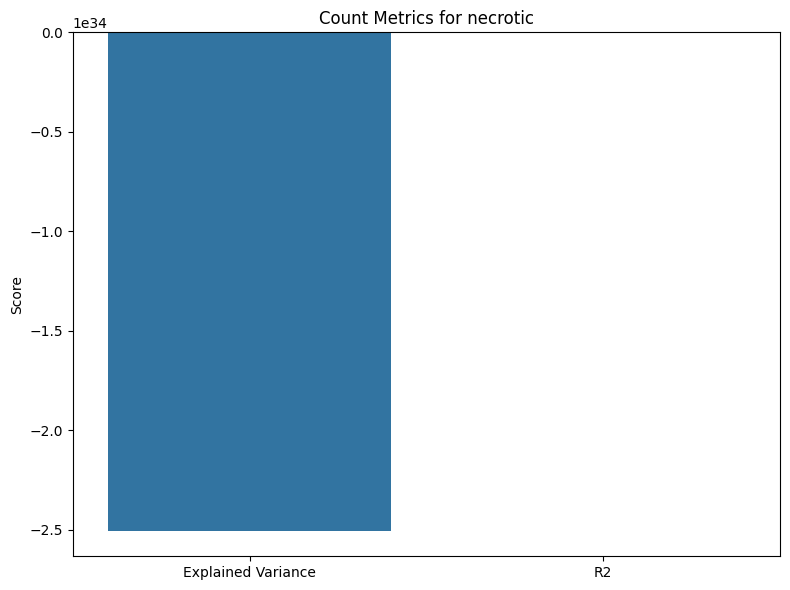

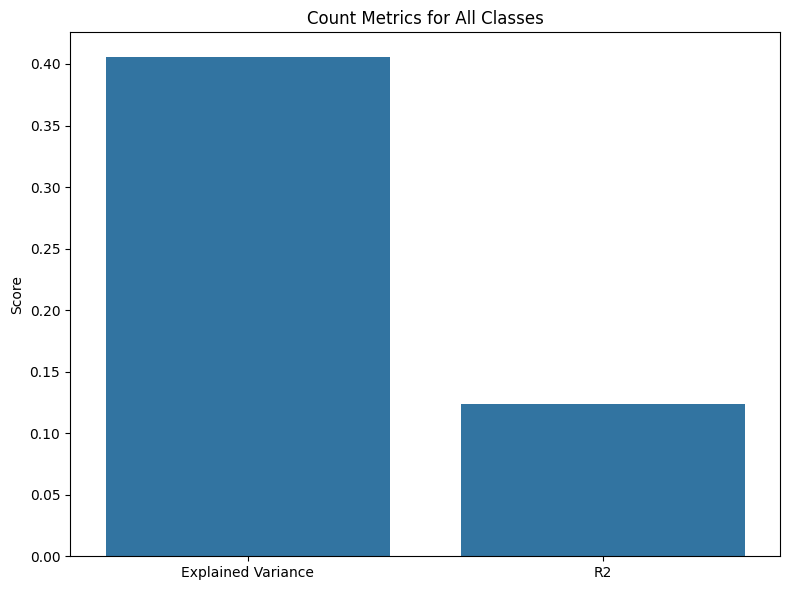

In [34]:
count_metrics = evaluate_quantification_metrics(
    all_results["quantification_gt_flat"]["counts"],
    all_results["quantification_predictions_flat"]["counts"],
    config["to_classes"],
    "Count"
)

plot_quantification_metrics(count_metrics, "Count")